# Discriminating motion from flux variation
Given a point detection in either a "proper subtraction" image or a "translient subtraction" image, we would like to know what the likely cause of the transient detection is. 

## Model
To do so we use the following image pair model where we now allow observed flux variation,

$$R = (T + \alpha\delta_{q+\Delta/2})*P_r + \epsilon_r,$$
$$N = (T + \beta\delta_{q-\Delta/2})*P_n + \epsilon_n.$$

Defining the following frequency domain difference image

$$\hat D \equiv \hat{P}_r\hat{N} - \hat{P}_n \hat{R} - \hat{P}_n\hat{P}_r(\alpha\hat{\delta}_{q+\Delta/2} - \beta\hat{\delta}_{q-\Delta/2}) = \hat{P}_n\hat\epsilon_r - \hat{P}_r\hat\epsilon_n,$$

we can express the log-likelihood of observing $\hat D$ for given $\alpha$, $\beta$, $q$ and $\Delta$ as

$$\log P(\hat D | \alpha, \beta, q, \Delta) = -\frac{1}{n^2} \sum_{k_x, k_y} \frac{|\hat{P}_r\hat{N} - \hat{P}_n \hat{R} - \hat{P}_n\hat{P}_r(\alpha\hat{\delta}_{q+\Delta/2} - \beta\hat{\delta}_{q-\Delta/2})|^2}{|\hat{P}_r|^2\sigma_n^2 + |\hat{P}_n|^2\sigma_r^2}.$$

We can specialize this expression to the small translation limit by keeping only terms first order in $\vec{k}\cdot\vec{\Delta}$. In this case 

$$\alpha\hat{\delta}_{q+\Delta/2} - \beta\hat{\delta}_{q-\Delta/2} \approx e^{-2\pi i\vec{k}\cdot\vec{q}/n} \left[(\alpha+\beta) - (\alpha - \beta)\frac{2\pi i (\vec{k}\cdot\vec{\Delta})}{n}\right].$$

We see that in this limit, a natural set of non-degenarate parameters for the likelihood are the flux difference $(\alpha - \beta)$, the flux addition multiplied by the magnitude of translation $(\alpha + \beta)|\Delta|$ and the direction of translation $\hat \Delta$.

## Performance evaluation

We now demonstrate how we can optimize the likelihood (or sample from it) for the above linearized 3-parameter likelihood surface, given a synthetic image pair

In [1]:
import math as ma
import numpy as np
import matplotlib.pyplot as plt
import numdifftools as nd

from numpy.fft import fftshift, fft2, ifft2
from scipy.optimize import minimize
from numpy.random import randn

from utils import gaussian_profile, d_statistic_nll_linearized, d_statistic_nll_full, delta_hat

## Synthesize some inputs

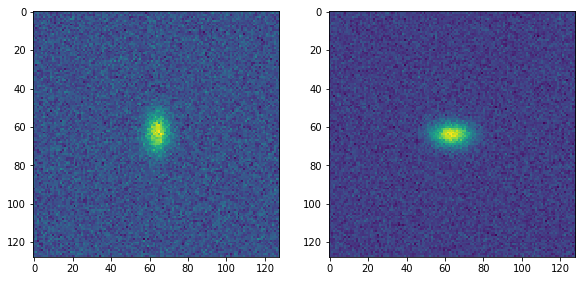

In [2]:
n = 128

q = np.array([n/2, n/2])
cxx_r, cxx_n = 5, 5
cyy_r, cyy_n = 3, 3
cth_r, cth_n = ma.pi/2, 0

sig_r = 0.001
sig_n = 0.001

Delta = np.array([1, -1]) * 0.5
alpha = 2
beta = 3

amb = alpha - beta
apb_Delta = (alpha + beta)*np.linalg.norm(Delta)
theta = ma.atan2(Delta[1], Delta[0])

x0_r, y0_r = (q + Delta)
x0_n, y0_n = (q - Delta)

P_r = fftshift(gaussian_profile(n/2-0.5, n/2-0.5, [n, n], cxx_r, cyy_r, cth_r))
P_n = fftshift(gaussian_profile(n/2-0.5, n/2-0.5, [n, n], cxx_n, cyy_n, cth_n))
R = np.real(alpha*ifft2(delta_hat([x0_r, y0_r], [n, n])*fft2(P_r))) + np.random.randn(n, n)*sig_r
N = np.real(beta *ifft2(delta_hat([x0_n, y0_n], [n, n])*fft2(P_n))) + np.random.randn(n, n)*sig_n

R_hat, N_hat, P_r_hat, P_n_hat = map(fft2,[R, N, P_r, P_n])

plt.figure(figsize=(15, 5))
plt.subplot(1,3,1); plt.imshow(R)
plt.subplot(1,3,2); plt.imshow(N)

## Visualizing the error surface (sans $\theta$)

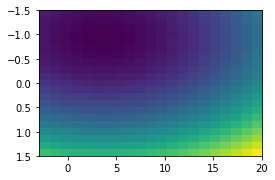

In [3]:
amb_ = np.linspace(-1.5, 1.5, 21)
apb_Delta_ = np.linspace(-3, 20, 21)
nll = np.zeros((amb_.shape[0], apb_Delta_.shape[0]))
for i, amb__ in enumerate(amb_):
    for j, apb_Delta__ in enumerate(apb_Delta_):
        nll[i,j] = d_statistic_nll_linearized(R_hat, N_hat, P_r_hat, P_n_hat, sig_r, sig_n, q, amb__, apb_Delta__, theta)

fig, ax = plt.subplots(figsize=(4,4))
ax.imshow((nll-np.min(nll)), extent=[apb_Delta_[0], apb_Delta_[-1], amb_[-1], amb_[0]])
ax.set_aspect(5)

## Find maximum-likelihood using Nelder-Mead

In [4]:
x0 = [0.0, 0.0, 0.0]
nll = lambda x : d_statistic_nll_linearized(R_hat, N_hat, P_r_hat, P_n_hat, sig_r, sig_n, q, x[0], x[1], x[2])
min_ = minimize(nll, x0, method='Nelder-Mead', options={'disp': False, 'ftol': 1e-15})

nll_hess = nd.Hessian(nll, step=0.1)
nll_hess_eval = nll_hess(min_.x)
nll_cov = np.linalg.inv(nll_hess_eval)
w, v = np.linalg.eig(nll_cov[:3, :3])

truth = np.array([amb, apb_Delta, theta])
estim = min_.x
sigmas = w**0.5
errors = estim - truth

np.set_printoptions(precision=3, floatmode='fixed', sign='+')

print('truth             ', truth)
print('estimate          ', estim)
print('sigmas            ', sigmas)
print('errors            ', errors)
print('errors in sigmas  ', errors / sigmas)

truth              [-1.000 +3.536 -0.785]
estimate           [-0.992 +3.267 -0.828]
sigmas             [+0.022 +0.191 +0.059]
errors             [+0.008 -0.269 -0.043]
errors in sigmas   [+0.387 -1.408 -0.734]


## Perform MCMC sampling

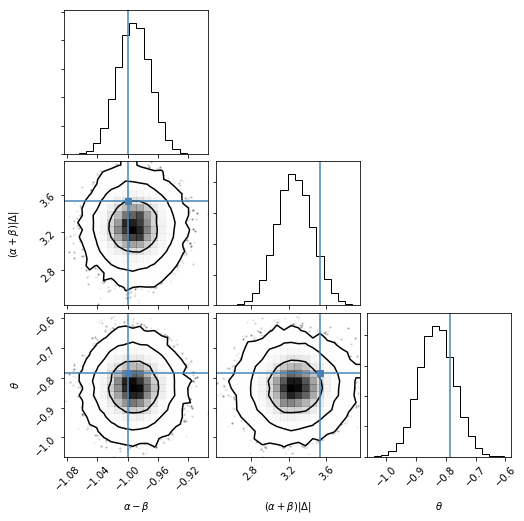

In [6]:
import emcee
import multiprocessing
import corner

ndim, nwalkers = 3, 300
num_threads = int(multiprocessing.cpu_count() / 2)

def lnprob(theta, R_hat, N_hat, P_r_hat, P_n_hat, sig_r, sig_n, q):    
    return -d_statistic_nll_linearized(R_hat, N_hat, P_r_hat, P_n_hat, sig_r, sig_n, q, 
                                       theta[0], theta[1], theta[2])

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, threads=num_threads, 
                                args=(R_hat, N_hat, P_r_hat, P_n_hat, sig_r, sig_n, q))

pos = [estim + 1e-1*np.random.randn(ndim) for i in range(nwalkers)]
sampler.run_mcmc(pos, 500);
samples = sampler.chain[:, 50:, :].reshape((-1, ndim))
fig = corner.corner(samples, 
                    labels=["$\\alpha-\\beta$", "$(\\alpha+\\beta)|\\Delta|$", "$\\theta$"], 
                    truths = truth, levels=(0.68, 0.95, 0.997,))